# Drift Detection

This example shows how to implement drift detection on MNIST dataset using the [TensorFlow Datasets](https://www.tensorflow.org/datasets) library.
You can find details about code bases on the following examples:

https://www.tensorflow.org/datasets/keras_example  
https://www.tensorflow.org/tutorials/images/data_augmentation

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from functools import partial

from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel
from frouros.callbacks import PermutationTestDistanceBased
import numpy as np

2023-07-27 09:49:29.932097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 09:49:29.956454: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 09:49:29.957018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 09:49:30.473334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## MNIST input pipeline
In order to simplify the input pipeline, we use the `tfds.load` function to download the MNIST dataset and load it directly into a `tf.data.Dataset` object. We also use the `as_supervised` argument to get the dataset in the (image, label) tuple format.


In [2]:
# Load the MNIST dataset
(ds_train, ds_test), metadata = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

INFO:absl:Load dataset info from /home/borja/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/borja/tensorflow_datasets/mnist/3.0.1)
2023-07-27 09:49:31.774442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-27 09:49:31.774708: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO:absl:Constructing tf.data.Dataset mnist for split ['train', 'test'], fro

After downloading the dataset, we define the normalization function to be applied to each image. We also define the batch size and the number of epochs to train the model.

In [3]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0


ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(metadata.splits["train"].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [4]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Create image encoder

We create a simple image encoder using the `tf.keras.Sequential` API. The encoder consists of a series of convolutional layers followed by a dense layer. The convolutional layers are used to extract features from the input image. The dense layer is used to reduce the dimensionality of the extracted features.


In [5]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(input_shape=(28, 28)),
            layers.Dense(latent_dim, activation="relu"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation="sigmoid"),
            layers.Reshape((28, 28, 1)),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(latent_dim=64)

In [6]:
autoencoder.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError())

We train the encoder using the `tf.GradientTape` API. We use the `tf.keras.losses.MeanSquaredError` API to compute the loss between the original image and the reconstructed image. We use the `tf.keras.optimizers.Adam` API to optimize the loss function.

In [7]:
_train = ds_train.map(lambda x: (x, x))
_test = ds_test.map(lambda x: (x, x))
autoencoder.fit(_train, epochs=3, validation_data=_test)

Epoch 1/3


1875/1875 [==============================] - 6s 2ms/step - loss: 0.0906 - val_loss: 0.0701
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0642 - val_loss: 0.0605
Epoch 3/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0598 - val_loss: 0.0591


## Data augmentation

To simulate the drift in the data, we apply random transformations to the images in the dataset. We use rotation to apply transformations to the images:


In [8]:
data_augmentation = tf.keras.Sequential([layers.RandomRotation(0.2)])
ds_augmented = ds_train.map(lambda x: data_augmentation(x))

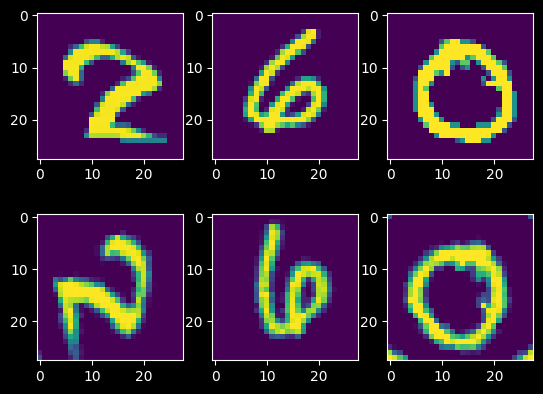

In [9]:
images = next(iter(ds_train)).numpy()
augmented = data_augmentation(images)
fig, ax = plt.subplots(nrows=2, ncols=3)

for i in range(ax.shape[1]):
    ax[0, i].imshow(images[i])
    ax[1, i].imshow(augmented[i])

## Data encoding

Before training the detector, we encode the images in the dataset using the encoder. We use the `tf.data.Dataset.map` API to apply the encoder to each image in the dataset.

In [10]:
encoded_train = ds_train.map(lambda x: autoencoder.encoder(x))
encoded_train = encoded_train.unbatch()
encoded_augmented = ds_augmented.map(lambda x: autoencoder.encoder(x))
encoded_augmented = encoded_augmented.unbatch()

## Data drift detection

Now the data have been encoded, we can train the detector and formulate our hypothesis.

A significance level of $\alpha = 0.05$ is set to perform the hypothesis test.


In [11]:
alpha = 0.05

In [12]:
num_samples = 1000
samples_train = encoded_train.take(num_samples).as_numpy_iterator()
samples_augmented = encoded_augmented.take(num_samples).as_numpy_iterator()

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a` imported from Frouros is used with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, p-value is estimated using permutation test.


In [13]:
detector = MMD(
    kernel=partial(rbf_kernel, sigma=0.5),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=100,
            num_jobs=-1,
            random_state=31,
            verbose=True,
            name="permutation_test",
        )
    ]
)
_ = detector.fit(X=np.stack(samples_train))

/home/borja/miniconda3/envs/DEEPaaS/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


Perform the hypothesis test using the fitted detector and the augmented images.

In [14]:
result, callbacks_log = detector.compare(X=np.stack(samples_augmented))
p_value = callbacks_log["permutation_test"]["p_value"]
print(f"MMD statistic={round(result.distance, 3)}, p-value={round(p_value, 3)}")
if p_value <= alpha:
    print("Drift detected. We can reject H0, so both samples come from different distributions.")
else:
    print("No drift detected. We fail to reject H0, so both samples come from the same distribution.")

100%|██████████| 100/100 [00:02<00:00, 48.50it/s]


MMD statistic=0.0, p-value=0.0
Drift detected. We can reject H0, so both samples come from different distributions.
